Dependecies and collecting images using openCV

In [3]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [4]:
import matplotlib.pyplot as plt
import json
import numpy as np


In [5]:
import os
import time
import uuid
import cv2


In [6]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 50

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [13]:
!labelme

Review dataset and build image loading function

In [7]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [8]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

b'data\\images\\3726c040-6b92-11ef-a449-a511a15c1722.jpg'

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[110, 113, 102],
        [109, 112, 101],
        [111, 114, 103],
        ...,
        [153, 157, 166],
        [156, 159, 168],
        [157, 160, 169]],

       [[110, 113, 102],
        [109, 113,  99],
        [109, 112, 101],
        ...,
        [153, 157, 166],
        [155, 158, 167],
        [157, 160, 167]],

       [[111, 115, 101],
        [108, 112,  97],
        [108, 112,  98],
        ...,
        [151, 158, 164],
        [154, 159, 165],
        [156, 161, 165]],

       ...,

       [[108,  94,  93],
        [108,  94,  93],
        [105,  94,  92],
        ...,
        [124, 116, 105],
        [124, 116, 105],
        [123, 115, 104]],

       [[109,  95,  94],
        [109,  95,  94],
        [109,  95,  94],
        ...,
        [125, 116, 107],
        [123, 114, 105],
        [121, 112, 103]],

       [[109,  95,  94],
        [109,  95,  94],
        [109,  95,  94],
        ...,
        [125, 116, 107],
        [123, 114, 105],
        [120, 111, 102]]

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

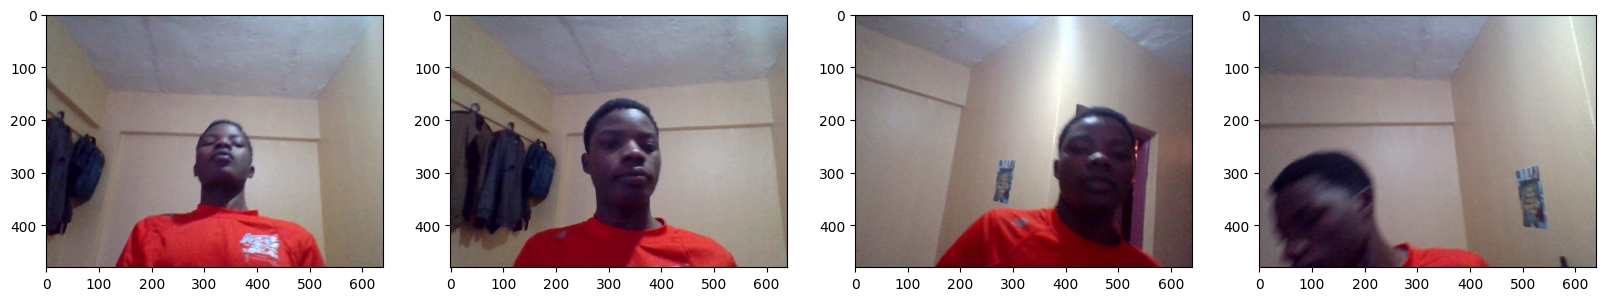

In [23]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data

In [28]:
# move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)



SETUP ALBUMENTATIONS TRANSFORM PIPELINE

In [20]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

In [46]:
img = cv2.imread(os.path.join('data','train','images','1a7b2367-6b92-11ef-9285-a511a15c1722.jpg'))
img.shape

(480, 640, 3)

In [32]:
#Load images
with open(os.path.join('data','train','labels','1a7b2367-6b92-11ef-9285-a511a15c1722.json'),'r') as f:
    label = json.load(f)

In [41]:
label['shapes'][0]['points']

[[228.02139037433156, 104.43850267379679],
 [390.0534759358288, 311.3903743315508]]

In [45]:
#Extract coordinates and rescale to match image resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[228.02139037433156, 104.43850267379679, 390.0534759358288, 311.3903743315508]

In [48]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3562834224598931,
 0.21758021390374332,
 0.6094585561497325,
 0.6487299465240641]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [53]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])
augmented['bboxes']

[(0.28226975638740354,
  0.3369102792632205,
  0.6423410576351751,
  0.7968033273915627)]

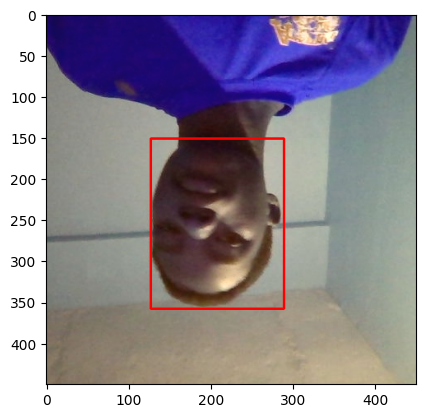

In [56]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])